In [1]:
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import warnings
import numpy as np

import os
import sys

from pickle import dump 
from pickle import load

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve

# Get the current working directory (the directory of the running script)
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, "NLP_Functions")))
from NLP_Functions.Preprocessing_Functions import Preprocessing, TextProcessingPipeline

sys.path.append(os.path.abspath(os.path.join(current_dir, "Classification_Functions")))
from Classification_Functions.Classification_Metrics_Functions import Metrics
from Classification_Functions.Preprocessing_Functions import Preprocessing

In [2]:
# Import the data frame from the logistic regression EDA
doc = pd.read_csv('Preprocessed_Data/Preprocessed_Data.csv')

doc.info()
doc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13035 entries, 0 to 13034
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   SAT                      13035 non-null  object
 1   MTranslation2            13035 non-null  object
 2   processed_MTranslation2  13035 non-null  object
 3   review_length            13035 non-null  int64 
 4   SAT_Target               13035 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 509.3+ KB


,SAT,MTranslation2,processed_MTranslation2,review_length,SAT_Target
0,Satisfied,Our support staff was very courteous. The with...,support staff courteous withdrawal defective p...,31,0
1,Satisfied,It's actually easy to chip production & proces...,actually easy chip production processor know h...,26,0
2,Satisfied,Take into account the first message sent to th...,take account first message send helpdesk repea...,16,0
3,Satisfied,Intel and Nuhr did well in servicing me. I t...,intel nuhr well servicing think one thing coul...,16,0
4,Satisfied,Improve the technical level and product profic...,improve technical level product proficiency 80...,42,0


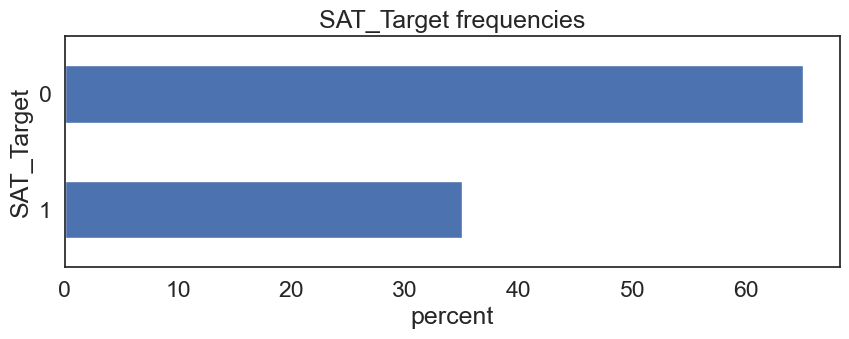

Satified: 65.12%
Not Satified: 34.88%


In [3]:
# Retaine missed_playoffs in a separate data frame
target_df = doc[['SAT_Target']].astype(str)

# missed_playoffs frequency
Preprocessing.cat_univariate_freq(
    df = target_df, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

# calculate the averages accross both classifications
not_satisfied_avg = round(doc['SAT_Target'].sum()/len(doc['SAT_Target'])*100,2)
satified_avg = round((len(doc['SAT_Target']) - doc['SAT_Target'].sum())/len(doc['SAT_Target'])*100,2)

print(f'Satified: {satified_avg}%')
print(f'Not Satified: {not_satisfied_avg}%')


             <------------------------------------ Train Data ------------------------------------>             



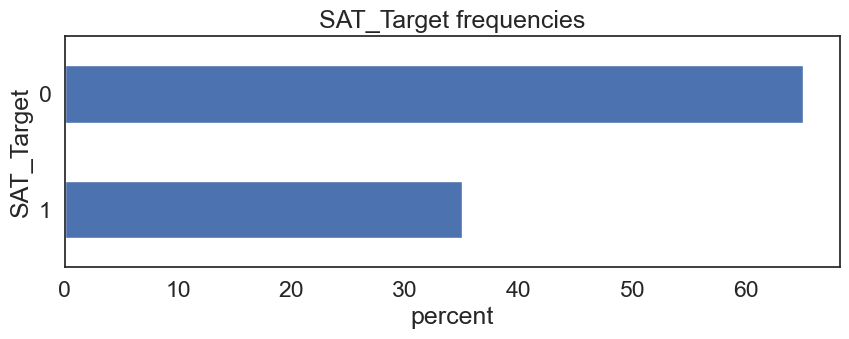

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9124 entries, 0 to 9123
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   processed_MTranslation2  9124 non-null   object
 1   SAT_Target               9124 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.7+ KB


,processed_MTranslation2,SAT_Target
0,ask whether anyone know vendor persistent memo...,1
1,return package get stick custom clearance day ...,0
2,spend quite bit time troubleshoot issue experi...,0



             <------------------------------------ Test Data ------------------------------------>              



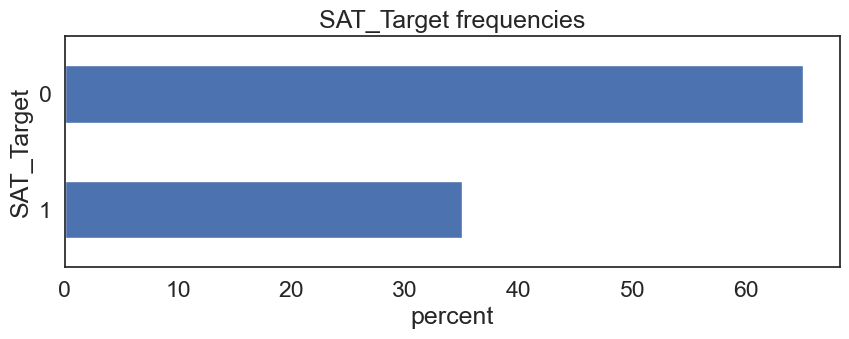

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   processed_MTranslation2  3911 non-null   object
 1   SAT_Target               3911 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 61.2+ KB


,processed_MTranslation2,SAT_Target
0,notice loss purchase certificate middle inquir...,0
1,honest one complain since rest reasonable thin...,0
2,call attendant cordial polite attentive speak ...,0


In [4]:
# Split the data into an 80/20 train and test stratified split by missed_playoffs frequency
split = StratifiedShuffleSplit(
    n_splits = 1, 
    test_size = 0.3, 
    random_state = 42
) 

for train_index, test_index in split.split(doc, doc['SAT_Target']):
    strat_train_set = doc.loc[train_index] 
    strat_test_set = doc.loc[test_index]
    

train_temp = strat_train_set[['SAT_Target']].astype(str).reset_index(drop=True)
strat_train_set = strat_train_set[['processed_MTranslation2','SAT_Target']].reset_index(drop=True)

test_temp = strat_test_set[['SAT_Target']].astype(str).reset_index(drop=True)
strat_test_set = strat_test_set[['processed_MTranslation2','SAT_Target']].reset_index(drop=True)

print(
    "\n",
    "<------------------------------------ Train Data ------------------------------------>".center(
        110
    ),
    "\n",
)
Preprocessing.cat_univariate_freq(
    df = train_temp, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

strat_train_set.info()
display(strat_train_set.head(3))

print(
    "\n",
    "<------------------------------------ Test Data ------------------------------------>".center(
        110
    ),
    "\n",
)
Preprocessing.cat_univariate_freq(
    df = test_temp, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

strat_test_set.info()
display(strat_test_set.head(3))

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Vectorize Text Data
vectorizer = TfidfVectorizer()

# Ensure 'processed_MTranslation2' is a Series (not a DataFrame)
X_train = vectorizer.fit_transform(strat_train_set['processed_MTranslation2'])  
y_train = strat_train_set['SAT_Target']

# K-Fold Cross-Validation
k_fold = StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.30)

# Initialize Logistic Regression Model
model = LogisticRegression(class_weight='balanced', solver='saga', max_iter=2000)

# Store results
accuracy_scores = []

print('\nTraining Logistic Regression Model with K-Fold Cross-Validation:\n')

# Train & Evaluate the Model using K-Fold
for fold, (train_index, test_index) in enumerate(k_fold.split(X_train, y_train), 1):
    # Split into training & testing sets
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train logistic regression model
    model.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_pred = model.predict(X_test_fold)

    # Compute accuracy
    accuracy = accuracy_score(y_test_fold, y_pred)
    accuracy_scores.append(accuracy)

    print(f"Fold {fold}: Accuracy = {accuracy:.4f}")

# Compute Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"\nAverage Accuracy across 10 folds: {avg_accuracy:.4f}")

# Final Model Evaluation
y_pred_train = model.predict(X_train)
print("\nFinal Classification Report:\n", classification_report(y_train, y_pred_train))


Training Logistic Regression Model with K-Fold Cross-Validation:

Fold 1: Accuracy = 0.7546
Fold 2: Accuracy = 0.7557
Fold 3: Accuracy = 0.7615
Fold 4: Accuracy = 0.7495
Fold 5: Accuracy = 0.7626
Fold 6: Accuracy = 0.7670
Fold 7: Accuracy = 0.7495
Fold 8: Accuracy = 0.7615
Fold 9: Accuracy = 0.7630
Fold 10: Accuracy = 0.7531

Average Accuracy across 10 folds: 0.7578

Final Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86      5942
           1       0.70      0.86      0.77      3182

    accuracy                           0.82      9124
   macro avg       0.81      0.83      0.81      9124
weighted avg       0.84      0.82      0.83      9124



In [6]:
# Create a data frame from the predicted results
y_pred_train = pd.DataFrame(y_pred_train, columns = ['predictions_train'])

# Creates a data frame from the prediction probabilities
proba = model.predict_proba(X_train)
proba = pd.DataFrame(proba, columns = ['0', 'predicted_proba'])

proba = proba[['predicted_proba']]

# Create a separate data frame from y_train
y_target = y_train.reset_index(drop = True)

# Concatenate all three data frames
data_frames = [
    y_target, 
    y_pred_train, 
    proba
]

results = pd.concat(data_frames, axis = 1)

# Print data summary
print('\n')
results.info()
display(results.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9124 entries, 0 to 9123
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SAT_Target         9124 non-null   int64  
 1   predictions_train  9124 non-null   int64  
 2   predicted_proba    9124 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


,SAT_Target,predictions_train,predicted_proba
0,1,1,0.636701
1,0,1,0.568674
2,0,0,0.084658
3,0,0,0.468265
4,0,1,0.824808


In [7]:
# Get model probability scores
y_probs = model.predict_proba(X_train)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_train, y_probs)

# Compute F1-score for each threshold
f1_scores = (2 * precision * recall) / (precision + recall)
f1_scores = f1_scores[:-1]  # Remove last NaN value (same length as `thresholds`)

# Get the threshold with the best F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {best_threshold}")

# Apply new threshold
y_pred_new = (y_probs >= best_threshold).astype(int)

# Evaluate new predictions
print("\nUpdated Classification Report:\n", classification_report(y_train, y_pred_new))

Optimal threshold: 0.5366502760228354

Updated Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      5942
           1       0.74      0.81      0.77      3182

    accuracy                           0.84      9124
   macro avg       0.82      0.83      0.82      9124
weighted avg       0.84      0.84      0.84      9124



In [8]:
# Adjust prediction threshold
proba_threshold = best_threshold

results['predictions_train'] = np.where(
    results['predicted_proba'] >= proba_threshold,
    1, 0
)

# Print data summary
print('\n')
results.info()
results.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9124 entries, 0 to 9123
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SAT_Target         9124 non-null   int64  
 1   predictions_train  9124 non-null   int32  
 2   predicted_proba    9124 non-null   float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 178.3 KB


,SAT_Target,predictions_train,predicted_proba
0,1,1,0.636701
1,0,1,0.568674
2,0,0,0.084658
3,0,0,0.468265
4,0,1,0.824808


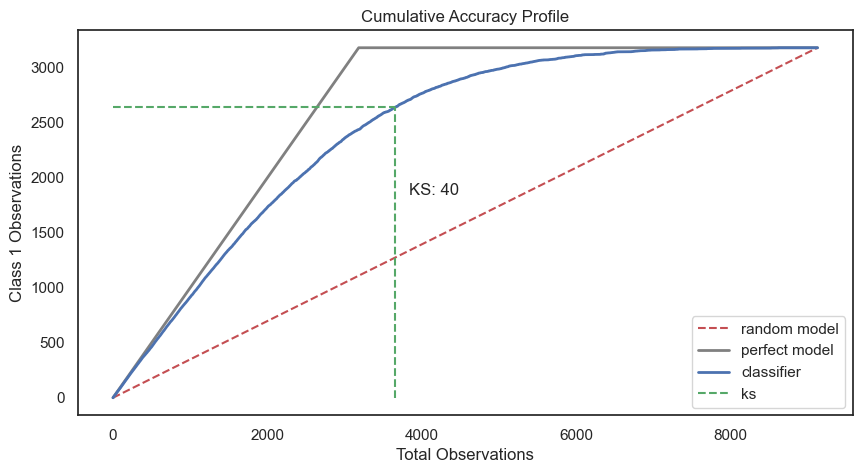

,bin,count_of_rows,total_target,model_percent,random_percent,model_cumm_percent,random_cumm_percent,ks
0,0,0,0,0.00,0,0.00,0,0.00
1,1,912,840,26.40,10,26.40,10,16.40
2,2,912,762,23.95,10,50.35,20,30.35
3,3,912,609,19.14,10,69.49,30,39.49
4,4,912,427,13.42,10,82.91,40,42.91
5,5,912,269,8.45,10,91.36,50,41.36
6,6,912,153,4.81,10,96.17,60,36.17
7,7,912,73,2.29,10,98.46,70,28.46
8,8,912,35,1.10,10,99.56,80,19.56
9,9,912,10,0.31,10,99.87,90,9.87


In [10]:
Metrics.generate_cap_curve_and_table(
    df=results,
    target='SAT_Target',
    y=y_target,
    y_score=proba,
    ks=40,
    text='KS: 40',
    font=1,
    width=10,
    length=5,
)